In [2]:
from collections import defaultdict
from glob import glob
from random import choice, sample

import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, LayerNormalization, BatchNormalization, Layer, Conv2D, InputSpec
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from tf2_keras_vggface.utils import preprocess_input
from tf2_keras_vggface.vggface import VGGFace

import os
import functools
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2021-08-11 14:18:19.339160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Using VGGFace compatible with TensorFlow2.


In [3]:
# Hyperparameters
BASE_MODEL = 'vgg16'
INPUT_SHAPE = (224, 224,)

# Modify paths as per your method of saving them
BASE_PATH = "/root/KinshipRecognition"
TRAIN_FILE_PATH = f"{BASE_PATH}/data/aug_train_ds.csv"
TRAIN_FOLDERS_PATH = f"{BASE_PATH}/data/train/train-faces/"

In [4]:
def read_img(path, input_shape):
    img = cv2.imread(path, -1)
    img = cv2.resize(img, input_shape)
    img = cv2.normalize(img,  np.zeros(img.shape[:2]), 0, 255, cv2.NORM_MINMAX)
    return np.array(img).astype(np.float)

In [5]:
# Load model
backbone = VGGFace(model=BASE_MODEL, include_top=False)
backbone.summary()


2021-08-11 14:18:20.517945: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-11 14:18:20.518691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-11 14:18:20.628559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-11 14:18:20.628589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-08-11 14:18:20.630158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-08-11 14:18:20.630213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, None, None, 64)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 128)   73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, None, None, 128)   147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, None, None, 128) 

In [6]:
# Load sample image
sample_img = glob(F"{TRAIN_FOLDERS_PATH}/*/*/*")[1250]
sample_img = read_img(sample_img, INPUT_SHAPE)
sample_img = tf.Variable(np.expand_dims(sample_img, axis=0), dtype=tf.float32, trainable=False) 


2021-08-11 14:18:21.954595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-08-11 14:18:23.096686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(1, 28, 28, 512)


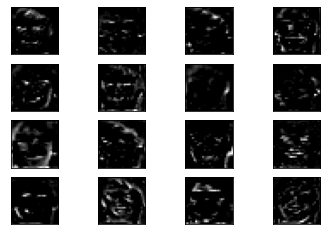

In [7]:
# Output for layer 1
inputs = Input(shape=INPUT_SHAPE + (3,))
seq = Sequential()
seq.add(inputs)
for l in backbone.layers[:12]:
    seq.add(l)
out = seq(sample_img)
print(out.shape)
ix = 1
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(out[0, :, :, 32+ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [8]:
class SelfAttentionKernel(Layer):
    
    def __init__(self, units, kernel_dim2D, key_dim, 
                 query_dim=None, value_dim=None, output_dim=None,
                 kernel_initializer="glorot_uniform", kernel_regularizer='l2', **kwargs):
    
        super(SelfAttentionKernel, self).__init__(**kwargs)
        
        self.units = units # Same as num_output_channels
        self.key_dim = key_dim
        self.query_dim = query_dim if query_dim else key_dim
        self.value_dim = value_dim if value_dim else key_dim
        self.output_dim = output_dim if output_dim else key_dim
        assert len(kernel_dim.shape) == 2
        self.kernel_dim2D = kernel_dim
        self.kernel_len = kernel_dim[0] * kernel_dim[1]
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        
        self.key_w = None
        self.query_w = None
        self.value_w = None
        self.scale = self.key_dim ** -0.5
        
    def build(self, input_shape):
        
        self.query_w = self.add_weight(shape=(self.units, self.query_dim, self.output_dim),
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        self.key_w = self.add_weight(shape=(self.units, self.key_dim, self.output_dim),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     trainable=True)
        self.value_w = self.add_weight(shape=(self.units, self.value_dim, self.kernel_len),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     trainable=True)

    def call(self, query, value, key=None):    
        
        key = key if key else value
        # Required for self-attention
        for i in range(len(query.shape)):
            assert query.shape[i] == key.shape[i]
            assert query.shape[i] == value.shape[i]
        
        qW = tf.matmul(tf.expand_dims(query, 1), self.query_w)
        kW = tf.matmul(tf.expand_dims(key, 1), self.key_w)
        dot = tf.matmul(qW, tf.transpose(kW, perm=(0, 1, 3, 2,)))
        attn_w = tf.nn.softmax(dot * self.scale)
        vW = tf.matmul(tf.expand_dims(value, 1), self.value_w)
        flat_kernel = tf.einsum('ijkl, ijlm -> ijkm', attn_w, vW)
        
        return kernel
    


In [9]:
from tensorflow.python.ops import nn_ops
import functools

class FixedConv2D(Conv2D):

    def __init__(self,
                 filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 groups=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):

        super(FixedConv2D, self).__init__(filters,
                                          kernel_size,
                                          strides=(1, 1),
                                          padding='valid',
                                          data_format=None,
                                          dilation_rate=(1, 1),
                                          groups=1,
                                          activation=None,
                                          use_bias=True,
                                          kernel_initializer='glorot_uniform',
                                          bias_initializer='zeros',
                                          kernel_regularizer=None,
                                          bias_regularizer=None,
                                          activity_regularizer=None,
                                          kernel_constraint=None,
                                          bias_constraint=None,
                                          **kwargs)

    def build(self, input_shape):
        input_shape = tf.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % self.groups != 0:
            raise ValueError(
              'The number of input channels must be evenly divisible by the number '
              'of groups. Received groups={}, but the input has {} channels '
              '(full input shape is {}).'.format(self.groups, input_channel,
                                                 input_shape))
        kernel_shape = self.kernel_size + (input_channel // self.groups,
                                           self.filters)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer='zeros',
            trainable=False,
            dtype=self.dtype)
        if self.use_bias:
            self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
            self.bias = None
        channel_axis = self._get_channel_axis()
        self.input_spec = InputSpec(min_ndim=self.rank + 2,
                                    axes={channel_axis: input_channel})

        # Convert Keras formats to TF native formats.
        if self.padding == 'causal':
            tf_padding = 'VALID'  # Causal padding handled in `call`.
        elif isinstance(self.padding, str):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding
        tf_dilations = list(self.dilation_rate)
        tf_strides = list(self.strides)

        tf_op_name = self.__class__.__name__
        if tf_op_name == 'Conv1D':
            tf_op_name = 'conv1d'  # Backwards compat.

        self._convolution_op = functools.partial(
            nn_ops.convolution_v2,
            strides=tf_strides,
            padding=tf_padding,
            dilations=tf_dilations,
            data_format=self._tf_data_format,
            name=tf_op_name)
        self.built = True

In [10]:
conv = FixedConv2D(2, (4, 4), trainable=False)

In [11]:
conv.build((224, 224, 3,))

In [12]:
conv.weights[1].trainable


False

In [13]:
conv.kernel.shape

TensorShape([4, 4, 3, 2])

In [31]:
q = tf.ones(shape=(5, 512, 784), dtype=tf.float32)
k = tf.ones(shape=(5, 512, 784), dtype=tf.float32)
v = tf.ones(shape=(5, 512, 784), dtype=tf.float32)
W = tf.ones(shape=(100, 784, 6), dtype=tf.float32)
qW = tf.matmul(tf.expand_dims(q, 1), W)
kW = tf.matmul(tf.expand_dims(k, 1), W)
dot = tf.matmul(qW, tf.transpose(kW, perm=(0, 1, 3, 2,)))
attn_w = tf.nn.softmax(dot)
vW = tf.matmul(tf.expand_dims(v, 1), W)
flat_kernel = tf.einsum('ijkl, ijlm -> ijkm', attn_w, vW)

In [32]:
# (batch, heads/out_channels, input_channels(512) ,kernel_size (a, b))

In [33]:
flat_kernel.shape

TensorShape([5, 100, 512, 6])

In [ ]:
flat_kernel.reshape()